<a href="https://colab.research.google.com/github/Leonid393/projects/blob/main/catboost_lightgbm_sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Цель работы

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

# Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Исследовательский анализ данных

Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [ ]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

In [ ]:
data_arc.info()
data_arc.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


In [ ]:
#для начала изабвимся от кириллического обозначения столбцов и неверного формата даты
data_arc.columns= ['key', 'arc_heat_start', 'arc_heat_end', 'active_power', 'reactive_power']
data_arc['arc_heat_start'] = pd.to_datetime(data_arc['arc_heat_start'], format="%Y-%m-%d %H:%M:%S")
data_arc['arc_heat_end'] = pd.to_datetime(data_arc['arc_heat_end'], format="%Y-%m-%d %H:%M:%S")

In [ ]:
data_arc.describe()

,key,active_power,reactive_power
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Отрицательное значение реактивной мощности - янвый выброс. Сохраню список партий с недоставерными данными.

In [ ]:
data_arc_query = data_arc.query("reactive_power < 0")
bad_key_arc = data_arc_query['key'].unique()

In [ ]:
power_coef = data_arc.query("key != 2116").copy()

power_coef['coef'] = power_coef['active_power'] / power_coef['reactive_power']

print('%-ое соотношение замеров в которых реактивная мощность больше активной - {:.0%}'
          .format(len(power_coef.query("coef < 1").key.unique())/len(data_arc['key'].unique())))

coef_key = power_coef.query("coef < 1").key.unique()

%-ое соотношение замеров в которых реактивная мощность больше активной - 7%


In [ ]:
bad_key = np.concatenate((bad_key_arc, coef_key))

In [ ]:
data_bulk.info()
data_bulk.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [ ]:
#избавимся от пробелов и заглавных букв в столбцах
bulk_index = ['key', 'bulk_1','bulk_2','bulk_3','bulk_4','bulk_5','bulk_6','bulk_7','bulk_8','bulk_9','bulk_10','bulk_11','bulk_12','bulk_13','bulk_14','bulk_15',]
data_bulk.columns = bulk_index

In [ ]:
data_bulk.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [ ]:
data_bulk = data_bulk.fillna(0)
data_bulk = data_bulk.astype('int')

Данные по подаче сыпучих материалов, NaN - не подавали материалы. Заполняю на нулевые значения и меняю тип данных 

In [ ]:
data_bulk_time.info()
data_bulk_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [ ]:
data_bulk_time.columns = bulk_index
time_cols_list = data_bulk_time.columns[1:16]
data_bulk_time[time_cols_list] = data_bulk_time[time_cols_list].apply(lambda x : pd.to_datetime(x, format = "%Y-%m-%d %H:%M:%S"))

In [ ]:
data_gas.info()
data_gas.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [ ]:
data_gas.columns = ['key','gas_1']

In [ ]:
print(len(data_gas))

3239


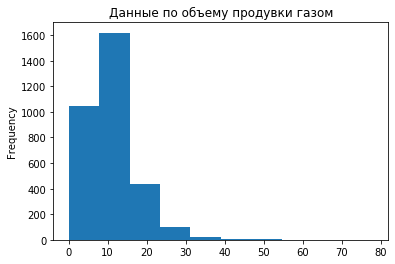

In [ ]:
data_gas['gas_1'].plot(kind='hist', title='Данные по объему продувки газом')

In [ ]:
data_gas.describe()

,key,gas_1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Количество выбросов по объему газа - 4%


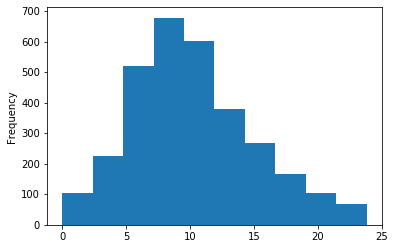

In [ ]:
q1_gas = data_gas['gas_1'].quantile(0.25)
q3_gas = data_gas['gas_1'].quantile(0.75)
iqr_gas = q3_gas - q1_gas
print('Количество выбросов по объему газа - {:.0%}'.format((len(data_gas) - len(data_gas.query("gas_1 > (@q1_gas - 1.5*@iqr_gas) and gas_1 < (@q3_gas + 1.5*@iqr_gas)")))/len(data_gas)))
data_gas.query("gas_1 > (@q1_gas - 1.5*@iqr_gas) and gas_1 < (@q3_gas + 1.5*@iqr_gas)").gas_1.plot(kind='hist')

In [ ]:
bad_gas_key = data_gas.query("gas_1 < (@q1_gas - 1.5*@iqr_gas) or gas_1 > (@q3_gas + 1.5*@iqr_gas)").key.unique()
bad_key = np.concatenate((bad_key, bad_gas_key))
bad_key = np.unique(bad_key)

In [ ]:
print(len(bad_key))

322


In [ ]:
data_temp.info()
data_temp.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [ ]:
data_temp.columns = ['key', 'measure_time', 'temp']
data_temp['measure_time'] = pd.to_datetime(data_temp['measure_time'], format="%Y-%m-%d %H:%M:%S")

In [ ]:
data_temp.describe()

,key,temp
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


In [ ]:
print('Количество замеров с аномально низкой температурой - {:.0f}'.format(len(data_temp.query("temp < 1500").key.unique())))
bad_key = np.concatenate((bad_key, data_temp.query("temp < 1500").key.unique()))
bad_key = np.unique(bad_key)

Количество замеров с аномально низкой температурой - 6


In [ ]:
temp_grouped = data_temp.groupby(by='key', as_index=False).count()

In [ ]:
bad_temp_key = temp_grouped.query("measure_time != temp")
bad_key = np.concatenate((bad_key, bad_temp_key['key'].unique()))
bad_key=np.unique(bad_key)

In [ ]:
print(len(bad_key))

991


In [ ]:
data_wire.info()
data_wire.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
wire_index = ['key','wire_1','wire_2','wire_3','wire_4','wire_5','wire_6','wire_7','wire_8','wire_9']
data_wire.columns = wire_index

In [ ]:
data_wire = data_wire.fillna(0)
data_wire = data_wire.astype('int')

In [ ]:
data_wire.describe()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000
mean,1623.426485,99.826355,17.637131,3.869198,0.260305,0.004869,1.132749,0.034729,0.329438,0.319701
std,932.996726,42.805617,33.420590,30.279608,4.283130,0.270237,8.929717,0.752762,4.374313,3.794053
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,823.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1619.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2434.000000,125.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3241.000000,330.000000,282.000000,385.000000,113.000000,15.000000,180.000000,32.000000,102.000000,90.000000


In [ ]:
data_wire_time.info()
data_wire_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_wire_time.columns = wire_index
time_cols_list = data_wire_time.columns[1:10]
data_wire_time[time_cols_list] = data_wire_time[time_cols_list].apply(lambda x : pd.to_datetime(x, format = "%Y-%m-%d %H:%M:%S"))

### Выводы и уточняющие вопросы

По итогу обработки и первичного анализа данных получил 991 выбросов по следующим признакам:<br>
1) аномальные значения активной и реактивной мощности<br>
2) исключил выбросы по объему подаваемого газа<br>
3) исключил измерения по ключам в которых температура ниже температуры плавления металла<br>
4) исключил замеры в которых отсутствовали измерения температуры (тут самое большое количество выбросов)<br>

Так как измерения температуры является нашим целевым признаком, то заменить/использовать неполные данные не представляется возможным.

## План решения задачи

Следующие шаги_v2:<br>
1) объединение датафреймов<br>
2) исключение данных по списку "плохих" ключей bad_key<br>
3) масштабирование признаков<br>
4) анализ мультиколлинеарности (корреляция?)<br>
5) уравновешивание признаков<br>
6) создание моделей машинного обучения<br>
7) анализ важности факторов<br>
8) анализ результатов и выводы<br>

## Подготовка к созданию моделей

### Объединение датафреймов

In [ ]:
data_arc_fin = data_arc.pivot_table(index='key', values=['active_power','reactive_power'], 
                                    aggfunc={'active_power':sum,'reactive_power':sum})

In [ ]:
last_measure_time = data_temp.pivot_table(index='key', values='measure_time', aggfunc=max)
last_measure_time_list = list(last_measure_time['measure_time'])
data_temp_fin = data_temp.query('measure_time in @last_measure_time_list')

In [ ]:
data_bulk_indexed = data_bulk.set_index('key')
data_wire_indexed = data_wire.set_index('key')
data_temp_indexed = data_temp_fin.set_index('key')

In [ ]:
data_merged = data_arc_fin.join([data_bulk_indexed,data_gas,data_wire_indexed,data_temp_indexed['temp']], how='outer')

In [ ]:
data_bulk_time2=data_bulk_time
data_bulk_time2['last_bulk'] = data_bulk_time[data_bulk_time.columns[1:16]].max(axis=1)

In [ ]:
data_wire_time2=data_wire_time
data_wire_time2['last_wire']=data_bulk_time[data_bulk_time.columns[1:16]].max(axis=1)

In [ ]:
last_arc_time = data_arc.pivot_table(index='key', values='arc_heat_end', aggfunc=max)
last_bulk_time = data_bulk_time2[['key','last_bulk']]
last_wire_time = data_wire_time2[['key', 'last_wire']]
last_bulk_time = last_bulk_time.set_index('key')
last_wire_time = last_wire_time.set_index('key')
last_time_merged = last_measure_time.join([last_arc_time,last_bulk_time,last_wire_time], how='outer')

In [ ]:
last_time_merged['max'] = last_time_merged.max(axis=1)

In [ ]:
bad_time_list = list(last_time_merged.query("measure_time != max").index)

In [ ]:
#bad_key = np.concatenate((bad_key, bad_time_list))
#bad_key=np.unique(bad_key)

In [ ]:
data_merged2 = data_merged.query("key not in @bad_key")
data_merged3 = data_merged2.dropna()

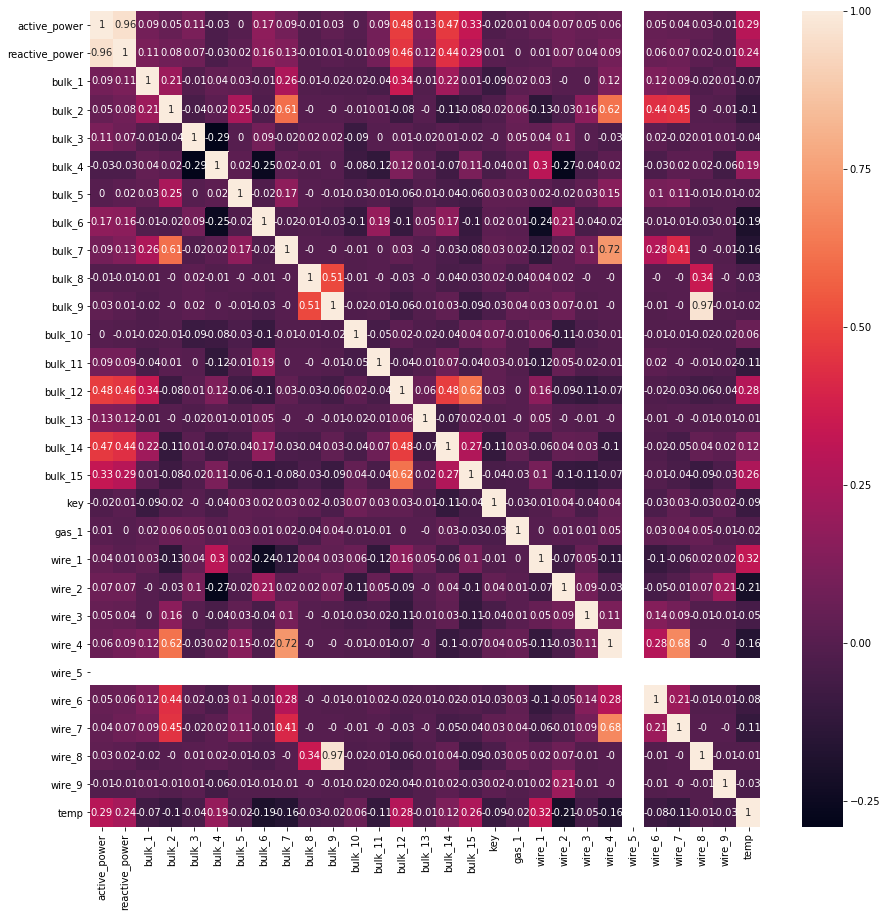

In [ ]:
plt.figure(figsize=(15, 15))
sns.heatmap(data_merged3.corr().round(2), annot=True)

Видим что wire_4/bulk_9 и active_power/reactive_power сильно коррелируют. Исключаем..

In [ ]:
data_merged5 = data_merged3.drop(['reactive_power', 'bulk_9', 'wire_5','bulk_8', 'bulk_10', 'wire_7', 'wire_8','wire_9', 'key'],axis=1)

In [ ]:
data_merged4 = data_merged3.drop(['bulk_9', 'wire_5', 'key'],axis=1)

In [ ]:
#data_merged4['full_power'] = (data_merged4['active_power']**2 + data_merged4['reactive_power']**2)**0.5
#data_merged4 = data_merged4.drop(['active_power', 'reactive_power'],axis=1)

In [ ]:
data_merged4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2086 entries, 1 to 2496
Data columns (total 26 columns):
active_power      2086 non-null float64
reactive_power    2086 non-null float64
bulk_1            2086 non-null float64
bulk_2            2086 non-null float64
bulk_3            2086 non-null float64
bulk_4            2086 non-null float64
bulk_5            2086 non-null float64
bulk_6            2086 non-null float64
bulk_7            2086 non-null float64
bulk_8            2086 non-null float64
bulk_10           2086 non-null float64
bulk_11           2086 non-null float64
bulk_12           2086 non-null float64
bulk_13           2086 non-null float64
bulk_14           2086 non-null float64
bulk_15           2086 non-null float64
gas_1             2086 non-null float64
wire_1            2086 non-null float64
wire_2            2086 non-null float64
wire_3            2086 non-null float64
wire_4            2086 non-null float64
wire_6            2086 non-null float64
wire_7       

### Обучение моделей

In [ ]:
features = data_merged4.drop('temp', axis=1)
target = data_merged4['temp']

In [ ]:
features_train, features2, target_train, target2 = train_test_split(features, target, 
                                                                    test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features2, target2, 
                                                                            test_size=0.4, random_state=12345)

In [ ]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)
features_test = scaler.transform(features_test)

In [ ]:
model_lin = LinearRegression()
model_lin.fit(features_train, target_train)
predictions_lin = model_lin.predict(features_valid)
result_lin = mean_absolute_error(target_valid, predictions_lin)
print("Результат модели линейной регрессии =: {:.2f}".format(result_lin))

Результат модели линейной регрессии =: 7.18


In [ ]:
best_model_tree = None
best_result_tree = 1000
best_depth_tree = 0

for depth in range(1, 20):
    model_tree = DecisionTreeRegressor(random_state=12345, max_depth = depth)
    model_tree.fit(features_train, target_train)
    predictions_tree = model_tree.predict(features_valid)
    result_tree = mean_absolute_error(target_valid, predictions_tree)
    if result_tree < best_result_tree:
        best_model_tree = model_tree
        best_result_tree = result_tree
        best_depth_tree = depth
        
print("Лучший результат дерева решений = : {:.2f}".format(best_result_tree),
      "Глубина дерева:", best_depth_tree)

Лучший результат дерева решений = : 7.19 Глубина дерева: 4


In [ ]:
best_model_forest = None
best_result_forest = 1000
best_depth_forest = 0
best_est = 0

for est in range (10, 80, 10):
    for depth in range (1, 21, 1):
        model_forest = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth = depth)
        model_forest.fit(features_train, target_train)
        predictions_forest = model_forest.predict(features_valid)
        result_forest = mean_absolute_error(target_valid, predictions_forest)
        if result_forest < best_result_forest:
            best_model_forest = model_forest
            best_depth_forest = depth
            best_result_forest = result_forest
            best_est = est

print("Лучший результат модели случайного леса =: {:.2f}".format(best_result_forest), 
      "Глубина дерева:", best_depth_forest,
     "Количество деревьев:", best_est)

Лучший результат модели случайного леса =: 6.78 Глубина дерева: 9 Количество деревьев: 60


In [ ]:
best_model_lgb = None
best_result_lgb = 1000
best_est_lgb = 0
best_leaves_lgb = 0
lgb_rate = [0.01, 0.1, 0.5, 1]

for leave in range(10, 50, 10):
    for est in range(1, 15, 1):
        for rate in range(len(lgb_rate)):
            model_lgb = LGBMRegressor(learning_rate=lgb_rate[rate], est=est, num_leaves = leave)
            model_lgb.fit(features_train, target_train)
            lgb_prediction = model_lgb.predict(features_valid)
            result_lgb = mean_absolute_error(target_valid, lgb_prediction)
            if result_lgb < best_result_lgb:
                best_model_lgb = model_lgb
                best_result_lgb = result_lgb
                best_leaves_lgb = leave
                best_est_lgb = est
                best_lgb_rate = lgb_rate[rate]

print("Лучший результат модели LGBM =: {:.2f}".format(best_result_lgb),
     "Количество деревьев =: {:.0f}".format(best_est_lgb),
     "Количество листьев =: {:.0f}".format(best_leaves_lgb),
     "learning rate = ",best_lgb_rate)

Лучший результат модели LGBM =: 6.94 Количество деревьев =: 1 Количество листьев =: 10 learning rate =  0.1


In [ ]:
best_model_cat = None
best_result_cat = 1000
best_iter_cat = 0
best_bepth_cat = 0
cat_rate = [0.01, 0.1, 0.5, 1]

for iter in range(10, 100, 10):
    for depth in range(1, 5 ,1):
        for rate in range(len(cat_rate)):
            model_cat = CatBoostRegressor(learning_rate=cat_rate[rate], iterations=iter, depth=depth, silent=True)
            model_cat.fit(features_train, target_train)
            cat_prediction = model_cat.predict(features_valid)
            result_cat = mean_absolute_error(target_valid, cat_prediction)
            if result_cat < best_result_cat:
                best_model_cat = model_cat
                best_result_cat = result_cat
                best_iter_cat = iter
                best_depth_cat = depth
                best_rate_cate = cat_rate[rate]

print("Результат модели Catboost =: {:.2f}".format(best_result_cat),
     "Количество итераций =: {:.2f}".format(best_iter_cat),
     "Глубина =: {:.2f}".format(best_depth_cat),
     "learning rate =",best_rate_cate)

Результат модели Catboost =: 6.91 Количество итераций =: 90.00 Глубина =: 4.00 learning rate = 0.1


In [ ]:
#features_joined = pd.DataFrame(features_train)
#target_joined = pd.DataFrame(target_train)

features_joined = pd.concat([pd.DataFrame(features_train), pd.DataFrame(features_valid)])
target_joined = pd.concat([pd.DataFrame(target_train), pd.DataFrame(target_valid)])

In [ ]:
model_lin.fit(features_joined,target_joined)
best_model_tree.fit(features_joined,target_joined)
best_model_forest.fit(features_joined,target_joined)
best_model_lgb.fit(features_joined,target_joined)
best_model_cat.fit(features_joined,target_joined)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
final_predict_lin = model_lin.predict(features_test)
final_predict_tree = best_model_tree.predict(features_test)
final_predict_forest = best_model_forest.predict(features_test)
final_predict_lgb = best_model_lgb.predict(features_test)
final_predict_cat = best_model_cat.predict(features_test)

final_result_lin = mean_absolute_error(target_test, final_predict_lin)
final_result_tree = mean_absolute_error(target_test, final_predict_tree)
final_result_forest = mean_absolute_error(target_test, final_predict_forest)
final_result_lgb = mean_absolute_error(target_test, final_predict_lgb)
final_result_cat = mean_absolute_error(target_test, final_predict_cat)

In [ ]:
def plot_importance(model,title):
    feature_names = features.columns
    importance = pd.Series(model.feature_importances_,index=feature_names)
    importance.plot.bar(title=title)

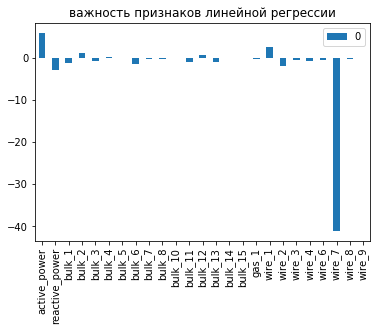

In [ ]:
#тут что то пошло не так
feature_names = features.columns
importance_lin = pd.DataFrame(model_lin.coef_.ravel(),index=feature_names)
importance_lin.plot.bar(title='важность признаков линейной регрессии')

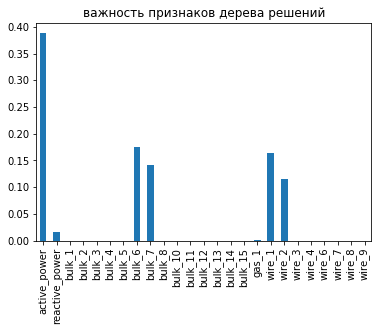

In [ ]:
plot_importance(best_model_tree, 'важность признаков дерева решений')

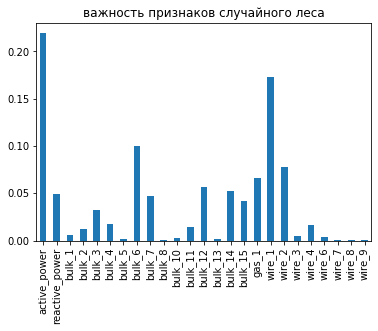

In [ ]:
plot_importance(best_model_forest, 'важность признаков случайного леса')

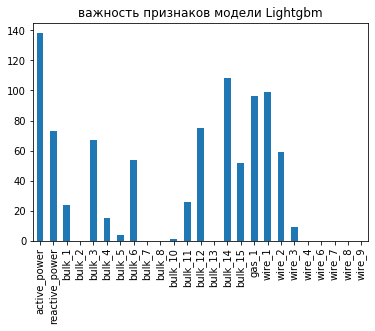

In [ ]:
plot_importance(best_model_lgb, 'важность признаков модели Lightgbm')

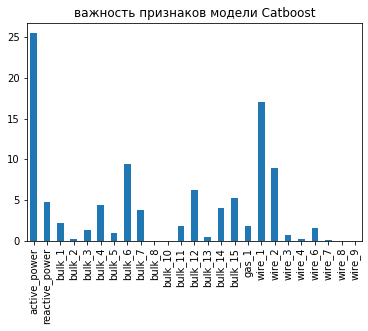

In [ ]:
plot_importance(best_model_cat, 'важность признаков модели Catboost')

In [ ]:
total_score = [['Дерево решений',best_result_tree, final_result_tree],
              ['Случайный лес',best_result_forest, final_result_forest],
              ['Линейная регрессия',result_lin, final_result_lin],
              ['LightGBM',best_result_lgb, final_result_lgb],
              ['Catboost',best_result_cat, final_result_cat]]
total_score = pd.DataFrame(total_score, columns = ['Модель', 'Результат MAE на валидации', 'Результат MAE на тесте'])
display(total_score)

,Модель,Результат MAE на валидации,Результат MAE на тесте
0,Дерево решений,7.186853,7.039764
1,Случайный лес,6.783287,6.788515
2,Линейная регрессия,7.182347,7.252573
3,LightGBM,6.939003,6.767161
4,Catboost,6.912493,6.672825


В целом все модели справились с поставленной задачей достигнуть MAE меньше 8.7. Во всех самым важным признаком все же является активная мощность. Прослеживается какая то зависимость точности и непосредственно количества признаков которая использует модель. 

Целевой признак: последняя измеренная температура.

Метрика: MAE

Критерии оценки

- MAE > 8.7 — 0 sp
- 7.6 < MAE ≤ 8.7 — 4 sp
- 6.8 < MAE ≤ 7.6 — 4.5 sp
- 6.3 < MAE ≤ 6.8 — 5 sp
- 6.0 < MAE ≤ 6.3 — 5.5 sp
- MAE ≤ 6.0 — 6 sp

В целом как рекомендация для дальнейшего планирования производства по выплавке - производить после включения проволочных добавок 

1) Какие пункты плана были выполнены, а какие — нет (поясните почему)?<br>
    - объединение датафреймов произвел по признакам без учета времени, так как нас интерисует итоговые цифры;<br>
    - исключил часть данных по причинам недостоверности/не полноты;<br>
    - масштабирование произведено;<br>
    - исходя из мультиколлинеарности исключил показания двух признаков. Тут у меня встречный вопрос. Ладно, в текущей выборке эти признаки исключены, а в будущем они ведь могут понадобиться?;<br>
    - создание моделей произведено;<br>
    - важность признаков оценена;<br>
    - вывод сделан.<br>        
2) Какие трудности возникли и как вы их преодолели?<br>
    Основная трудность заключалась в достижении итоговой метрики, достиг путем оптимизации входящих признаков.<br>
3) Какие ключевые шаги в решении задачи выделили?<br>
    Считаю что ключевым шагом в задании было предобработка самих данных и подготовка признаков для обучения. В целом все модели показали схожий итоговый результат.<br>
4) Какая ваша итоговая модель и какое у неё качество?<br>
    Итоговой моделью все же является Catboost, с лучшим итоговым результатом 6,67.<br>